# Predicting the Category of a Jeopardy! Question using Logistic Regression

In [1]:
!pip install portalocker

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import torch
import torchtext
import torchdata
import portalocker
import json
import pandas as pd
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset, DataLoader
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

In [3]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
device

from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
filename = 'gdrive/MyDrive/Colab Notebooks/JEOPARDY_CSV.csv'

with open(filename, 'r', encoding='iso-8859-1') as f:
    df = pd.read_csv(f)

In [5]:
df = df[[' Category', ' Question']]
df = df.rename(columns={' Question': 'Question',' Category': 'Category'})
df = df.sample(frac=0.8,random_state=200)

In [6]:
most_common_cat_count = df['Category'].value_counts().nlargest(4)
most_common_cat_count

BEFORE & AFTER      440
SCIENCE             428
LITERATURE          394
AMERICAN HISTORY    324
Name: Category, dtype: int64

In [7]:
most_common_cat = most_common_cat_count.index.tolist()
df = df[df['Category'].isin(most_common_cat)]
encode_dict = {}

def encode_cat(x):
    if x not in encode_dict.keys():
        encode_dict[x]=len(encode_dict)
    return encode_dict[x]

df['ENCODE_CAT'] = df['Category'].apply(lambda x: encode_cat(x))
df['ENCODE_CAT'].unique()

<ipython-input-7-aaf53764c5d0>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ENCODE_CAT'] = df['Category'].apply(lambda x: encode_cat(x))


array([0, 1, 2, 3])

In [8]:
# split into train, valid and test dataset
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(df, train_size=0.9, test_size=0.1, random_state = 200)

In [9]:
train_iter = iter(train_data.Question)

In [10]:
tokenizer = get_tokenizer('basic_english')
def yield_tokens(train_iter):
    for text in train_iter:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(
    yield_tokens(train_iter), specials=["<unk>"], min_freq=1000)

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

tokenizer = get_tokenizer('basic_english')

tfidf_vectorizer = TfidfVectorizer(tokenizer=tokenizer, max_features=len(vocab))
tfidf_vectorizer.fit(train_data['Question'])

inputs = tfidf_vectorizer.transform(train_data['Question'])

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [12]:
test_inputs = tfidf_vectorizer.transform(test_data['Question'])

In [13]:
# split training data further into train and validation set
targets = train_data.ENCODE_CAT
train_inputs, val_inputs, train_targets, val_targets = train_test_split(inputs, targets, test_size = 0.2)
test_targets = test_data.ENCODE_CAT

In [14]:
# convert into pytorch tensors
train_input_tensors = torch.tensor(train_inputs.toarray()).float()
val_input_tensors = torch.tensor(val_inputs.toarray()).float()
test_input_tensors = torch.tensor(test_inputs.toarray()).float()

train_target_tensors = torch.tensor(train_targets.values)
val_target_tensors = torch.tensor(val_targets.values)
test_target_tensors = torch.tensor(test_targets.values)

In [15]:
# create dataloaders
BATCH_SIZE = 64

train_ds = TensorDataset(train_target_tensors, train_input_tensors)
val_ds = TensorDataset(val_target_tensors, val_input_tensors)
test_ds = TensorDataset(test_target_tensors, test_input_tensors)

train_dataloader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=True)

In [16]:
from torch import nn
import torch.nn.functional as F

class TFIDFClassifier(nn.Module):
    def __init__(self, num_labels, vocab_size):
        super(TFIDFClassifier, self).__init__()
        self.linear = nn.Linear(vocab_size, num_labels)
    
    def forward(self, vec):
        return F.log_softmax(self.linear(vec), dim=1)

In [17]:
num_labels = len(df['ENCODE_CAT'].unique())
vocab_size = len(vocab)
model = TFIDFClassifier(num_labels, vocab_size)

### Create function to train one epoch

In [18]:
import time

loss_function = torch.nn.NLLLoss()

def train_an_epoch(dataloader, optimizer):
    model.train() # Sets the module in training mode.
    log_interval = 500

    for idx, (label, text) in enumerate(dataloader):
        model.zero_grad()
        log_probs = model(text) # forward pass
        loss = loss_function(log_probs, label)
        loss.backward()
        optimizer.step()
        if idx % log_interval == 0 and idx > 0:
            print(f'At iteration {idx} the loss is {loss:.3f}.')

### Create function to compute accuracy

In [19]:
def get_accuracy(dataloader):
    model.eval() # switch to indicate that the model is not in training mode
    with torch.no_grad(): # disables gradient calculation (for when you are sure you will not call Tensor.backward()). This will reduce memory consumption.
        total_examples = 0
        correct = 0
        for labels, text in dataloader: # for each batch in dataloader
            total_examples += text.shape[0]
            probs = model(text)
            preds = probs.argmax(1)
            correct += (torch.eq(preds, labels)).sum().item()
        overall_accuracy = correct / total_examples
        return overall_accuracy


### Training


After epoch 1 the validation accuracy is 0.406.


After epoch 2 the validation accuracy is 0.406.


After epoch 3 the validation accuracy is 0.395.


After epoch 4 the validation accuracy is 0.406.


After epoch 5 the validation accuracy is 0.406.


After epoch 6 the validation accuracy is 0.392.


After epoch 7 the validation accuracy is 0.304.


After epoch 8 the validation accuracy is 0.388.


After epoch 9 the validation accuracy is 0.322.


After epoch 10 the validation accuracy is 0.304.



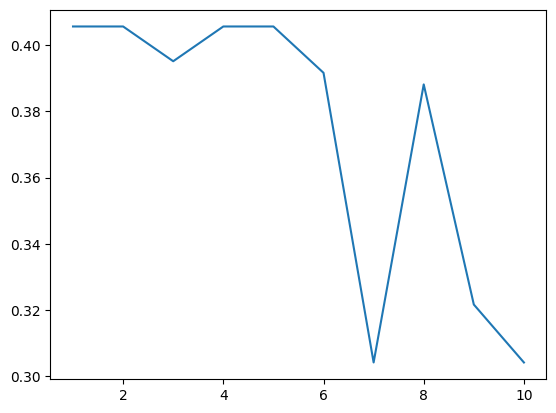

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

EPOCHS = 10
optimizer = torch.optim.SGD(model.parameters(), lr=3)

accuracies=[]
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train_an_epoch(train_dataloader, optimizer)
    accuracy = get_accuracy(valid_dataloader)
    accuracies.append(accuracy)
    time_taken = time.time() - epoch_start_time
    print()
    print(f'After epoch {epoch} the validation accuracy is {accuracy:.3f}.')
    print()
    
plt.plot(range(1, EPOCHS+1), accuracies)

After running for only 10 epochs, we see the validation accuracy begins to drop past the sixth epoch. To prevent overfitting, we set the optimal number of epochs to be 6 and train the model again on just six epochs.

In [22]:
# create dataloaders
BATCH_SIZE = 64

train_ds = TensorDataset(train_target_tensors, train_input_tensors)
val_ds = TensorDataset(val_target_tensors, val_input_tensors)
test_ds = TensorDataset(test_target_tensors, test_input_tensors)

train_dataloader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=True)

num_labels = len(df['ENCODE_CAT'].unique())
vocab_size = len(vocab)
model = TFIDFClassifier(num_labels, vocab_size)

import matplotlib.pyplot as plt
%matplotlib inline

EPOCHS = 6
optimizer = torch.optim.SGD(model.parameters(), lr=3)

accuracies=[]
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train_an_epoch(train_dataloader, optimizer)
    accuracy = get_accuracy(valid_dataloader)
    accuracies.append(accuracy)
    time_taken = time.time() - epoch_start_time

In [23]:
test_accuracy = get_accuracy(test_dataloader)
print("test accuracy from model trained on 50 epochs:", test_accuracy)

test accuracy from model trained on 50 epochs: 0.3018867924528302
